In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

# Helper Functions

In [3]:
def run_query(q, db="chinook.db"):
    """Takes in an SQL query and runs it against the
    chinook.db database using pandas' read_sql_query 
    method.
    q: str
        The SQL query
        
    db: str (default 'chinook.db')
        Path to the database file.
    return: pd.DataFrame
        Query(q) result is returned in dataframe format.
    
    -------
    Examples:
    query = "SELECT * FROM customers;"
    customers = run_query(query)
    """
    with sqlite3.connect(db) as conn:
        return pd.read_sql_query(q, conn)

def run_command(c, db="chinook.db"):
    """ Takes in an SQL query which don't return anything
    and execute it against the chinook.db database.
    c: str
        SQL command to be executed against the specified
        database. There won't be anything to return
    db: [optional] str
        Path to the database file against of which the
        command will be executed.
        
    return:
    
    """
    with sqlite3.connect(db) as conn:
        conn.isolation_leve = None
        conn.execute(c)

def show_tables(db="chinook.db"):
    """Gathers a list of all the tables and views available
    in the specified database and returns it.
    
    db: str
        Path to the database on which operations will
        be carried out. Defaults to "chinook.db"
    return: 
        Returns a list of tables and views in the
        specified database.
    """
    query = """
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view")"""
    return run_query(query)

In [4]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Task 1
We are tasked to **find out which genres best sell in the USA**. So let's get to it..

For each genre type, we'll find out the total number of tracks sold to USA customers. Also we'll find out the percentage share of each genre based on the tracks sold of that genre.

In [5]:
query_t1 = """
WITH usa_track_genres AS (
    SELECT 
        g.name AS genre,
        il.track_id AS track_id
    FROM invoice_line as il
    INNER JOIN invoice as inv ON il.invoice_id = inv.invoice_id
    LEFT JOIN customer as c ON inv.customer_id = c.customer_id
    INNER JOIN track as t ON il.track_id = t.track_id
    INNER JOIN genre as g ON t.genre_id = g.genre_id
    WHERE c.country = 'USA')
    
SELECT
    genre,
    COUNT(track_id) AS tracks_sold,
    CAST(COUNT(track_id) as float)/(SELECT COUNT(*) FROM usa_track_genres) as genre_share
FROM usa_track_genres
GROUP BY genre
ORDER BY COUNT(track_id) DESC
LIMIT 10;
"""

# top_genres_usa['genre_share'] = top_genres_usa.tracks_sold/top_genres_usa.tracks_sold.sum()
run_query(query_t1)

,genre,tracks_sold,genre_share
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


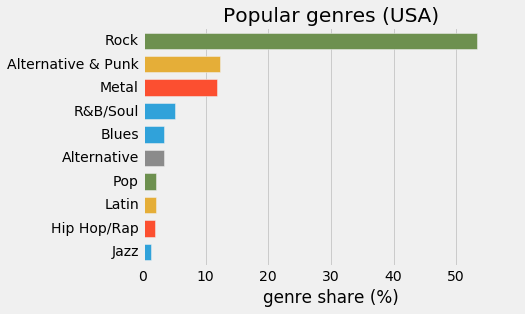

In [37]:
top_genres = run_query(query_t1)
ax = (top_genres
    .set_index(keys=['genre'])
    .sort_values('tracks_sold', ascending=True)
    .genre_share
    .map(lambda x: x*100)
    .plot.barh(legend=False,
               title = 'Popular genres (USA)',
               width = 0.7)
)
ax.set(xlabel = 'genre share (%)',
       ylabel = '')
majorLocator = np.arange(0,51,10)
ax.set_xticks(majorLocator, minor=False)
ax.grid(which='major', axis='y')

### Task 1 inferences
Looking at the chart above, which depicts the percentage share of all the genres' tracks sold in the USA, **"Rock"** with no doubt is the most popular and most sold music genre (in USA). So, if we'were tasked with choosing three artists from the four of four different genres as:
1.  Hip-Hop
2.  Punk
3.  Pop and
4.  Blues

It would be fair to select artists of the genres (in order of most to least popularity):
1. Punk
2. Blues
3. Pop

Although, there's only slight difference of about 0.1% in the share of Pop and Hip-Hop, so someone might prefer Hip-Hop artists over pop for their store.

## Task 2

We are tasked to analyze the purchases of customers belonging to each employee to **see if any Sales Support Agent is performing either better or worse than the others**.

To tackle this problem, we'll make a table relating the sales associated to each Sales Support Agent and some other relevant variables that'll explain the variance in results.

In [7]:
query_t2 = """
WITH sales_agents AS (
    SELECT e.*
    FROM employee AS e
    WHERE e.title = 'Sales Support Agent'
    )
    

SELECT
    e.first_name || " " || e.last_name as employee_name,
    SUBSTR(e.hire_date, 1, 10) as hired_on,
    SUM(i.total) as sales
FROM sales_agents as e
LEFT JOIN customer as c ON e.employee_id = c.support_rep_id
LEFT JOIN invoice as i ON i.customer_id = c.customer_id
GROUP BY e.first_name || " " || e.last_name, e.country, e.hire_date
"""

sales_agent_performance = run_query(query_t2)
run_query(query_t2)

,employee_name,hired_on,sales
0,Jane Peacock,2017-04-01,1731.51
1,Margaret Park,2017-05-03,1584.00
2,Steve Johnson,2017-10-17,1393.92


In [8]:
sales_agent_performance.sales.agg([np.mean, np.std])

mean    1569.810000
std      169.241748
Name: sales, dtype: float64

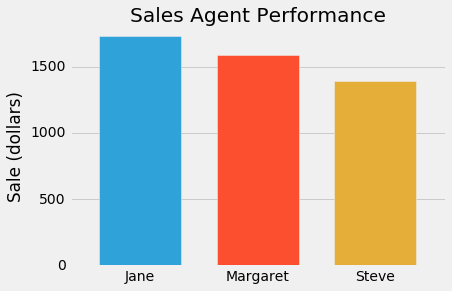

In [40]:
# Let's visualize the result
ax = (sales_agent_performance
    .set_index('employee_name')
    .sales
    .plot.bar(width = 0.7)
)
ax.set(xlabel = '',
       ylabel = 'Sale (dollars)',
       title = 'Sales Agent Performance')
xticklabels = [name.split()[0] for name in sales_agent_performance.employee_name]
ax.set_xticklabels(xticklabels, rotation=0, ha='center')
ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.grid(axis='x')

### Task 2 Inferences

- As you can see in the chart above there're only 3 sales support agents and, **Jane is clearly the best perfomer of them all**.
- The fact than she's been hired 1 and 6 months prior to **Margaret and Steve** respectively puts her at an advantage.
- It also helps us make sense as to why she's done better in sales compared to other Sales Support Agents.

## Task 3

We are tasked to **calculate data, for each country**, on:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [10]:
query_t3 = """
WITH
    -- All the following subqueries produce results
    -- which are grouped into countries
    
    -- customer_counts produces number of customers by each country
    customer_counts AS (
        SELECT
            country,
            COUNT(customer_id) as customer_count
        FROM customer
        GROUP BY country
        ORDER BY COUNT(customer_id) DESC
    ),
    
    -- total_sales produces total sale associated with each country
    total_sales AS (
        SELECT
            c.country,
            SUM(i.total) as total_sale,
            COUNT(i.invoice_id) as order_count
        FROM customer as c
        INNER JOIN invoice as i ON i.customer_id = c.customer_id
        GROUP BY c.country
        ORDER BY SUM(i.total) DESC
    ),
    
    -- country_wise_data combine the country wise sales and 
    -- customer counts to produce more columns such as
    -- average customer value,
    -- average order value,etc..
    -- It produces a table grouped by countries except
    -- countries with 1 customer count are renamed as 'Other'
    country_wise_data AS (
        SELECT
            cc.customer_count,
            ts.total_sale as total_sale,
            ts.order_count,
            ts.total_sale/cc.customer_count as avg_sale,
            ts.total_sale/ts.order_count as avg_order,
            CASE
                WHEN cc.customer_count != 1 THEN cc.country
                ELSE 'Other'
                END AS country,
            -- Following column is added only for the purpose of ORDERING.
            -- Countries with 1 customer('Other' countires) have associated
            -- value equal to 0.
            CASE
                WHEN cc.customer_count != 1 THEN 1
                ELSE 0
                END AS other_separator
        FROM total_sales as ts
        INNER JOIN customer_counts as cc ON ts.country = cc.country
    )

-- MAIN QUERY
-- All the 'Other' named countries and associated 
-- statistics are aggregated appropriately to combine
-- them into single row with country named as 'Other'.
SELECT
    cd.country,
    SUM(cd.customer_count) as customer_count,
    SUM(cd.total_sale) AS total_sale,
    ROUND(CAST(SUM(cd.total_sale) AS float)/SUM(cd.customer_count), 2) AS sale_per_customer,
    ROUND(CAST(SUM(cd.total_sale) AS float)/SUM(cd.order_count), 2) AS sale_per_order
FROM country_wise_data as cd
GROUP BY cd.country
ORDER BY cd.other_separator DESC, cd.total_sale DESC;
"""

run_query(query_t3)

,country,customer_count,total_sale,sale_per_customer,sale_per_order
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.57,8.72
9,Other,15,1094.94,73.00,7.45


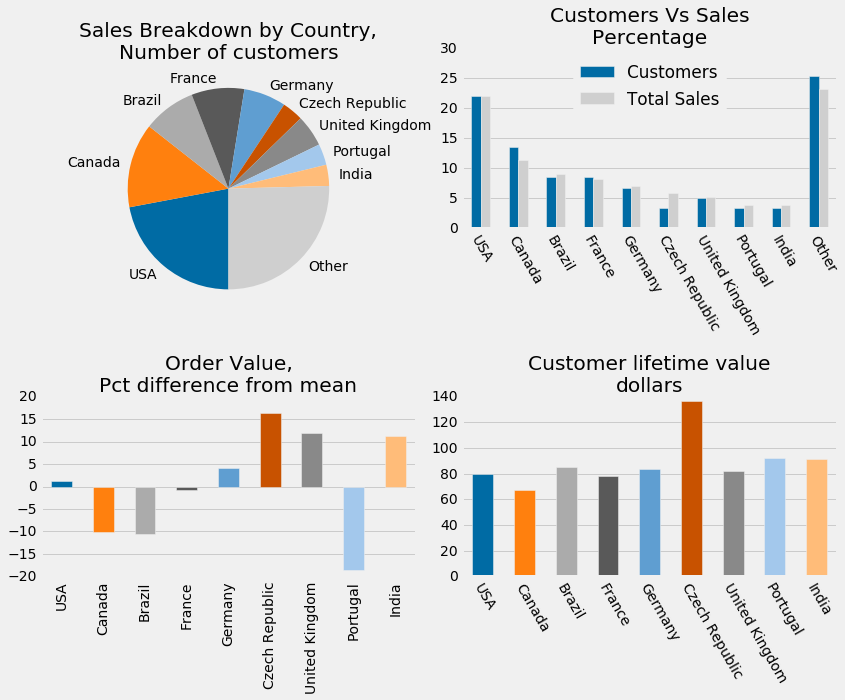

In [11]:
sales_data = run_query(query_t3)
sales_data.set_index('country', drop=True, inplace=True)
colors = [cm.Accent(i) for i in np.linspace(0, 1, sales_data.shape[0])]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
ax0, ax1, ax2, ax3 = ax.flatten()
fig.subplots_adjust(wspace=0.3, hspace=0.5)

# custom colormap - tableau's color blind 10
cblind10_colors = [(0.0, 0.4196078431372549, 0.6431372549019608),
            (1.0, 0.5019607843137255, 0.054901960784313725),
            (0.6705882352941176, 0.6705882352941176, 0.6705882352941176),
            (0.34901960784313724, 0.34901960784313724, 0.34901960784313724),
            (0.37254901960784315, 0.6196078431372549, 0.8196078431372549),
            (0.7843137254901961, 0.3215686274509804, 0.0),
            (0.5372549019607843, 0.5372549019607843, 0.5372549019607843),
            (0.6392156862745098, 0.7843137254901961, 0.9254901960784314),
            (1.0, 0.7372549019607844, 0.4745098039215686),
            (0.8117647058823529, 0.8117647058823529, 0.8117647058823529)]
cblind10 = mpl.colors.ListedColormap(cblind10_colors)
cblind10_r = mpl.colors.ListedColormap(cblind10_colors[::-1])
# Top left
sales_breakdown = sales_data['customer_count'].copy().rename('')
(sales_breakdown
    .plot.pie(ax = ax0,
              startangle = -90,
              counterclock = False,
              radius = 1,
              colormap = cblind10,
              textprops= {'fontsize':12},
              wedgeprops={'linewidth':0},
              title = 'Sales Breakdown by Country,\nNumber of customers')
)
ax0.set_aspect('equal') # set aspect ratio of 1 for pie chart.
# pos = ax0.axes.get_position()
# pos1 = [pos.x0, pos.y0 - 0.30, pos.width, pos.height + 0.15]


# Top right
customerVsSales = sales_data[['customer_count', 'total_sale']] * 100/sales_data[['customer_count', 'total_sale']].sum()
customerVsSales.index.name = ''
customerVsSales.plot.bar(ax = ax1,
                         colormap = cblind10,
                         title = 'Customers Vs Sales\nPercentage'
                        )
ax1.legend(['Customers', 'Total Sales'], loc='upper center')
plt.setp(ax1.get_xticklabels(), rotation=-60, ha='left', va='top', rotation_mode='anchor')
ax1.grid(axis='x')


# Bottom left
# avg order difference(in %) from mean. diffence can be positive or negative.
mu = sales_data.sale_per_order.mean()
orderDiff = (sales_data['sale_per_order'] - mu)*100/mu
try:
    orderDiff.drop(labels='Other', axis='index', inplace=True)
except:
    pass
orderDiff.name = ''
orderDiff.index.name = ''
orderDiff.plot.bar(ax=ax2,
                   color=cblind10_colors,
                   title='Order Value,\nPct difference from mean')
ax2.grid(axis='x')

# Bottom right
customerValue = sales_data.sale_per_customer.copy()
customerValue.drop(labels=['Other'], axis=0, inplace=True)
customerValue.index.name = ''
customerValue.plot.bar(ax=ax3,
                       color=cblind10_colors,
                       title='Customer lifetime value\ndollars')
plt.setp(ax3.get_xticklabels(), rotation=-60, ha='left', va='top', rotation_mode='anchor')
ax3.grid(axis='x')

plt.tight_layout()

# SHIFT pie chart a little downwards
# and increase height a little.
dy = -0.12
addHeight = 0.1
pos = ax0.axes.get_position()
new_pos = [pos.x0, pos.y0 + dy, pos.width, pos.height + addHeight]
ax0.axes.set_position(new_pos)

### Task 3 Inferences

- Considering individual countries, **USA possess the highest market share with 22% of total customer base**, followed by **Canada** and **Brazil** at about 13% and 8% respectively.


- Although, **Czech Republic** sits at the number 6 position in the list top market shares, **it has got the Higest Total_Sales vs Customers ratio**, indicating **highest lifetime customer value among all the countries**. This fact can clearly be seen in the bottom right chart.


- The chart on bottom left packs a lot of information in it. **When it comes to average order value, USA, France perform about the average line** while, **Czeck Republic outperformas all others**. It makes sense as to why Czeck Republic has the highest customer value.


- It is **interesting to note that, even though Portugal is performing worst in average order value chart, it has got quite a hold in lifetime customer value**.

## Task 4

We are tasked to **categorize each inovoice as either an album purchase or not**, and to calculate the summary statistics as follows:
- Number of invoices
- Percentage of invoices

In [12]:
query_t4 = """
WITH
    invoice_first_track AS (
        SELECT
            il.invoice_id AS invoice_id,
            MIN(il.track_id) AS first_track_id
        FROM invoice_line as il
        GROUP BY il.invoice_id
        ),

    invoice_album AS (
        SELECT
            ifs.invoice_id,
            ifs.first_track_id,
            al.album_id
        FROM invoice_first_track AS ifs
        INNER JOIN track AS t on t.track_id = ifs.first_track_id
        INNER JOIN album as al on t.album_id = al.album_id
    ),
    
    -- aps : album_purchase_statistics
    aps AS (
        SELECT
            ial.*,
            CASE
                WHEN
                    (
                        SELECT t1.track_id
                        FROM track AS t1
                        WHERE t1.album_id = ial.album_id
                    EXCEPT
                        SELECT il1.track_id
                        FROM invoice_line AS il1
                        WHERE il1.invoice_id = ial.invoice_id

                    ) IS NULL
                    AND
                    (
                        SELECT il2.track_id
                        FROM invoice_line AS il2
                        WHERE il2.invoice_id = ial.invoice_id
                    EXCEPT
                        SELECT t2.track_id
                        FROM track AS t2
                        WHERE t2.album_id = ial.album_id
                    ) IS NULL
                THEN 'Yes'
                ELSE 'No'
                END AS album_purchase
        FROM
            invoice_album AS ial
    )


SELECT
    st.album_purchase,
    COUNT(album_id) AS number_of_invoices,
    ROUND(CAST(COUNT(album_id) AS float)*100/(SELECT COUNT(album_id) FROM aps),2) AS percent
FROM
    -- aps: album_purchase_statistics
    aps as st
GROUP BY st.album_purchase
"""

# Run the query
run_query(query_t4)

,album_purchase,number_of_invoices,percent
0,No,500,81.43
1,Yes,114,18.57


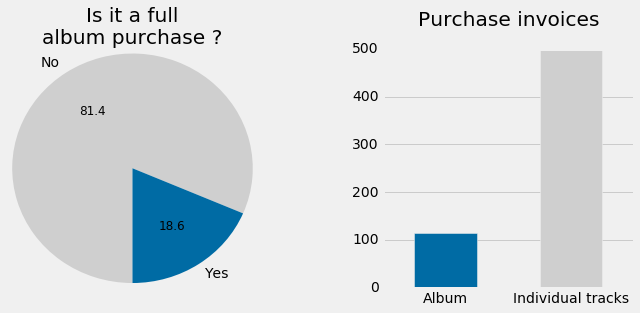

In [84]:
invoices_summary = run_query(query_t4)
invoices_summary.set_index('album_purchase', inplace=True)
invoices_summary.index.name = ''
percent = invoices_summary.percent
percent = percent.rename('')

fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.subplots_adjust(wspace=0.5)
ax0, ax1 = ax.flatten()
percent.plot.pie(ax=ax0,
                 radius=1.2,
                 counterclock=False,
                 startangle=-90,
                 colormap=cblind10_r,
                 wedgeprops={'linewidth':0},
                 textprops={'fontsize':12},
                 title='Is it a full\nalbum purchase ?',
                 autopct='%.1f')
# ax0.set_aspect('equal')

(invoices_summary
    .number_of_invoices
    .iloc[::-1]
    .plot.bar(ax = ax1,
              color = [cblind10_colors[0],cblind10_colors[-1]]))
ax1.set_xticklabels(['Album', 'Individual tracks'], rotation=0)
ax1.set_title('Purchase invoices', y=1.075)
ax1.grid(axis='x')

**About one in every five invoices is of a full album purchase.**

## Task 5

We are tasked to find out **which artist features in most number of playlists**.

In [86]:
query_t5 = """
SELECT
    ar.artist_id,
    ar.name,
    COUNT(DISTINCT pll.playlist_id) AS playlists_in,
    COUNT(DISTINCT pltr.track_id) AS unique_tracks_in_playlists,
    COUNT(pltr.track_id) AS total_playlist_appearances
FROM
    artist AS ar
    INNER JOIN album AS al ON al.artist_id = ar.artist_id
    INNER JOIN track AS t ON t.album_id = al.album_id
    INNER JOIN playlist_track AS pltr ON pltr.track_id = t.track_id
    INNER JOIN playlist AS pll ON pll.playlist_id = pltr.playlist_id
GROUP BY ar.artist_id, ar.name
--ORDER BY COUNT(pltr.track_id) DESC;
ORDER BY COUNT(DISTINCT pll.playlist_id) DESC, COUNT(DISTINCT pltr.track_id) DESC
LIMIT 10;
"""
run_query(query_t5)

,artist_id,name,playlists_in,unique_tracks_in_playlists,total_playlist_appearances
0,226,Eugene Ormandy,7,3,15
1,248,Berliner Philharmoniker & Herbert Von Karajan,6,3,13
2,208,English Concert & Trevor Pinnock,6,2,9
3,214,Academy of St. Martin in the Fields & Sir Nevi...,6,2,10
4,247,The King's Singers,6,2,10
5,245,Michael Tilson Thomas & San Francisco Symphony,5,2,10
6,206,Alberto Turco & Nova Schola Gregoriana,5,1,5
7,207,"Richard Marlow & The Choir of Trinity College,...",5,1,5
8,211,Wilhelm Kempff,5,1,5
9,212,Yo-Yo Ma,5,1,5


**Eugene Ormandy** with three distinct tracks having appeared in 7 different playlists total of 15 times **is the most popular artist** based on this particular criteria.